In [2]:
!pip3 install scikit-surprise



In [6]:
from surprise import NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
import numpy as np
import torch
from torch.optim import SGD
import cvxpy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Run Nonnegative Matrix Factorization

In [7]:

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Compute matrix factorization embeddings 
def get_embeddings(n_factors):
  algo = NMF(n_factors=n_factors)
  cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
  return algo.pu

# Compute threshold $\beta_u$

In [36]:

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for \alpha = [1, 1... ,1] 
def get_beta_threshold(user_embeddings_np, p=2):

  N = user_embeddings_np.shape[0] # number of users 
  q = 1/(1-1/p) # dual norm 
  
  normalized_user_embeddings = user_embeddings_np / np.linalg.norm(user_embeddings_np, ord=q, axis=1, keepdims=True)
  sum_of_rows = np.sum(normalized_user_embeddings, axis=0)
  beta_ub = np.log(N) / (np.log(N) - np.log(np.linalg.norm(sum_of_rows, ord=q)))
    
  return beta_ub

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for q = 2 
def get_beta_threshold_cost_weights(user_embeddings_np, cost_weights, p=2):

  N = user_embeddings_np.shape[0]
  normalized_user_embeddings = user_embeddings_np / np.linalg.norm(user_embeddings_np * np.power(cost_weights, -1), ord=2, axis=1, keepdims=True)
  sum_of_rows = np.sum(normalized_user_embeddings, axis=0)
  beta_ub = np.log(N) / (np.log(N) - np.log(np.linalg.norm(sum_of_rows * np.power(cost_weights, -1), ord=2)))

  return beta_ub





# Compute single-genre equilibrium $p^*$ 

In [ ]:

# Compute the single-genre equilibrium p^* for cost functions c_{q, \alpha, \beta} for q = 2 
def get_first_objective(U, dim, p=2, learning_rate=1.0, cost_weights=None):
    x = cp.Variable(dim)
    objective = cp.Maximize(cp.sum(cp.log(U @ x)))
    constraints = [cp.norm(cp.multiply(x, cost_weights), p) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    print(x.value)
    return x.value

# Project onto q-norm ball 
def project_onto_norm_ball(x, q, cost_weights):
    dim = len(x)
    y = cp.Variable(dim)
    objective = cp.Minimize(cp.norm2(x-y))
    constraints = [cp.norm(cp.multiply(y, cost_weights), q) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return y.value

# Compute the threshold value \beta_u for cost functions c_{q, \alpha, \beta} for \alpha = [1, 1... ,1] 
def get_first_objective_old(U, D, p=2, learning_rate=1.0, cost_weights=None):
  if cost_weights==None:
    cost_weights = torch.ones(D)

  x = torch.clamp(torch.randn(D), min=1.0)
  x.requires_grad = True
  optimizer = SGD([x], lr=learning_rate)
  num_iterations = 100

  for _ in tqdm(range(num_iterations)):
    optimizer.zero_grad()

    loss = -1 * torch.sum(torch.log(torch.matmul(U, x)))

    loss.backward()  # computes the gradient

    optimizer.step()

    with torch.no_grad():
      x.clamp_(min=0)
      x_numpy = x.detach().numpy()
      projected_x = project_onto_norm_ball(x_numpy, p, cost_weights)
      x.copy_(torch.from_numpy(projected_x))
  print(x)
  print("Objective:", -1 * loss.item())

  return x.detach().numpy(), -1 * loss.item()



# Generate data for plots 

In [ ]:

# Compute \beta_u data across different dimensions and values of q

def get_betas_upper_bound_all(p_values, dim_values):
  betas = []
  for j in range(len(dim_values)):
    betas_p = []
    dim = dim_values[j]
    user_embeddings_np = get_embeddings(dim)
    U = torch.from_numpy(user_embeddings_np.astype(np.float32))

    for i in range(len(p_values)):
      q = p_values[i]
      beta_ub = get_beta_threshold(user_embeddings_np, p=q)
      betas_p.append(beta_ub)

      print(f'beta value: {beta_ub} at D = {dim} at p = {q}')
      print('\n\n')

    betas.append(betas_p)
  return betas



In [37]:
# Compute single-genre equilibria data 

def get_data_costs_weighted(dim, costs_weights_all):
    user_embeddings = get_embeddings(dim)
    U = torch.from_numpy(user_embeddings.astype(np.float32))

    S = 4
    p_vals = []
    for i in range(S):
        cost_weights = costs_weights_all[i]
        p = get_first_objective(U, dim, p=2, cost_weights=cost_weights)
        p = p / np.linalg.norm(p)
        print(f'alpha = {cost_weights}, p = {p / np.sum(p)}')
        p_vals.append(p)

    mean_embedding = np.mean(user_embeddings,axis=0)
    mean_embedding = mean_embedding / np.linalg.norm(mean_embedding)

    return p_vals, user_embeddings, mean_embedding



def get_data_costs_qvals(dim, q_vals):
    user_embeddings = get_embeddings(dim)
    U = torch.from_numpy(user_embeddings.astype(np.float32))

    S = len(q_vals)
    p_vals = []
    for i in range(S):
        q = q_vals[i]
        p, loss = get_first_objective_old(U, dim, p=q, cost_weights=None)
        p = p / np.linalg.norm(p)
        print(f'q = {q}, p = {p}')
        p_vals.append(p)

    mean_embedding = np.mean(user_embeddings,axis=0)
    mean_embedding = mean_embedding / np.linalg.norm(mean_embedding)

    return p_vals, user_embeddings, mean_embedding



In [ ]:

# Generate S weight vectors \alpha 
def generate_cost_weights(dim, S):
  cost_weights_all = []
  if dim == 3:
    for i in range(S):
        cost_weights = torch.rand(dim)
        cost_weights = cost_weights / torch.sum(cost_weights)
        cost_weights_all.append(cost_weights)
  if dim == 2:
    for i in range(S):
        shift = 1/(2 * S)
        cost_weights = torch.zeros(dim)
        cost_weights[0] = shift + (i / (S+1))
        cost_weights[1] = 1 - cost_weights[0]
        cost_weights_all.append(cost_weights)
  return cost_weights_all

In [38]:

cost_weights_all_2d = generate_cost_weights(2, 4)
p_vals_weighted2, user_embeddings_weighted2, mean_embedding_weighted2  = get_data_costs_weighted(2, cost_weights_all_2d)

# Save data to a file
np.savetxt('./Data/p_vals_weighted2.txt', p_vals_weighted2)
np.savetxt('./Data/user_embeddings_weighted2.txt', user_embeddings_weighted2)
np.savetxt('./Data/mean_embedding_weighted2.txt', mean_embedding_weighted2)
np.savetxt('./Data/cost_weights_all_2d.txt', cost_weights_all_2d)



[7.88645674 0.19186523]
alpha = tensor([0.1250, 0.8750]), p = [0.97624937 0.02375063]
[2.7111838  0.70054125]
alpha = tensor([0.3250, 0.6750]), p = [0.79466656 0.20533344]
[1.25805875 1.58072188]
alpha = tensor([0.5250, 0.4750]), p = [0.44316871 0.55683129]
[0.5094442  3.37924224]
alpha = tensor([0.7250, 0.2750]), p = [0.13100676 0.86899324]


In [40]:

# Generate data
cost_weights_all_3d = generate_cost_weights(3, 4)
p_vals_weighted3, user_embeddings_weighted3, mean_embedding_weighted3 = get_data_costs_weighted(3, cost_weights_all_3d)

# Save data to file
np.savetxt('./Data/cost_weights_all_3d.txt', cost_weights_all_3d)
np.savetxt('./Data/p_vals_weighted3.txt', p_vals_weighted3)
np.savetxt('./Data/user_embeddings_weighted3.txt', user_embeddings_weighted3)
np.savetxt('./Data/mean_embedding_weighted3.txt', mean_embedding_weighted3)

[4.22575689 1.70253737 0.62708108]
alpha = tensor([0.1893, 0.2973, 0.5134]), p = [0.64462471 0.25971623 0.09565907]
[0.10782801 8.24624469 7.13945776]
alpha = tensor([0.8162, 0.0869, 0.0969]), p = [0.00695955 0.53223794 0.46080251]
[15.10621612  1.99093362  0.11639231]
alpha = tensor([0.0617, 0.1762, 0.7621]), p = [0.87757744 0.11566089 0.00676167]
[13.57984076  0.45849254  0.31352898]
alpha = tensor([0.0713, 0.4120, 0.5167]), p = [0.94620757 0.03194655 0.02184587]


In [69]:

q_vals = [1.1, 1.5, 2, 3, 4]

# Generate data
p_vals_qvals2, user_embeddings_qvals2, mean_embedding_qvals2 = get_data_costs_qvals(2, q_vals)

# Save data to files
np.savetxt('./Data/p_vals_qvals2.txt', p_vals_qvals2)
np.savetxt('./Data/user_embeddings_qvals2.txt', user_embeddings_qvals2)
np.savetxt('./Data/mean_embedding_qvals2.txt', mean_embedding_qvals2)
np.savetxt('./Data/q_vals.txt', q_vals)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 179.54it/s]


tensor([0.6365, 0.4264], requires_grad=True)
Objective: 230.26132202148438
q = 1.1, p = [0.8308143 0.5565498]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 232.70it/s]


tensor([0.6625, 0.5966], requires_grad=True)
Objective: 386.77911376953125
q = 1.5, p = [0.7430768  0.66920614]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 393.34it/s]


tensor([0.7260, 0.6877], requires_grad=True)
Objective: 495.38623046875
q = 2, p = [0.72596854 0.6877279 ]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 234.56it/s]


tensor([0.8046, 0.7825], requires_grad=True)
Objective: 604.1502685546875
q = 3, p = [0.7168811  0.69719535]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 227.39it/s]

tensor([0.8485, 0.8331], requires_grad=True)
Objective: 658.559814453125
q = 4, p = [0.71354795 0.70060647]


In [70]:
q_vals = [1.1, 1.5, 2, 3, 4]
# Generate data
p_vals_qvals3, user_embeddings_qvals3, mean_embedding_qvals3 = get_data_costs_qvals(3, q_vals)

# Save data to files
np.savetxt('./Data/p_vals_qvals3.txt', p_vals_qvals3)
np.savetxt('./Data/user_embeddings_qvals3.txt', user_embeddings_qvals3)
np.savetxt('./Data/mean_embedding_qvals3.txt', mean_embedding_qvals3)
np.savetxt('./Data/q_vals.txt', q_vals)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 174.73it/s]


tensor([0.3299, 0.3352, 0.4389], requires_grad=True)
Objective: 87.79789733886719
q = 1.1, p = [0.51278365 0.5210464  0.6823222 ]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 223.08it/s]


tensor([0.4678, 0.4690, 0.5050], requires_grad=True)
Objective: 338.0450439453125
q = 1.5, p = [0.5616237  0.56305104 0.60626096]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 391.67it/s]


tensor([0.5694, 0.5701, 0.5922], requires_grad=True)
Objective: 510.55670166015625
q = 2, p = [0.5694401 0.5700994 0.5922201]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 225.44it/s]


tensor([0.6884, 0.6888, 0.7027], requires_grad=True)
Objective: 683.1412963867188
q = 3, p = [0.573255   0.5735758  0.58514065]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 226.44it/s]

tensor([0.7563, 0.7566, 0.7664], requires_grad=True)
Objective: 769.4457397460938
q = 4, p = [0.57471526 0.57492685 0.58237565]


In [51]:
q_vals = [1.1, 1.5, 2, 3, 4]

dim_values = [2, 3, 5, 10, 50]

# Generate data
betas = get_betas_upper_bound_all(q_vals, dim_values)

# Save data to files
np.savetxt('./Data/betas.txt', betas)
np.savetxt('./Data/q_vals.txt', q_vals)
np.savetxt('./Data/dim_values.txt', dim_values)

beta value: 77.17237248136932 at D = 2 at p = 1.1



beta value: 180.41275761914218 at D = 2 at p = 1.5



beta value: 307.2784784152672 at D = 2 at p = 2



beta value: 560.1644512257153 at D = 2 at p = 3



beta value: 812.881787109587 at D = 2 at p = 4



beta value: 43.69996766087328 at D = 3 at p = 1.1



beta value: 99.87887647386083 at D = 3 at p = 1.5



beta value: 167.43366909167636 at D = 3 at p = 2



beta value: 300.1376820413199 at D = 3 at p = 3



beta value: 431.9531429212273 at D = 3 at p = 4



beta value: 27.046344939706124 at D = 5 at p = 1.1



beta value: 60.97395000089868 at D = 5 at p = 1.5



beta value: 102.75372338102032 at D = 5 at p = 2



beta value: 185.36640619437716 at D = 5 at p = 3



beta value: 267.59071857011816 at D = 5 at p = 4



beta value: 16.950643393475342 at D = 10 at p = 1.1



beta value: 37.32967784189925 at D = 10 at p = 1.5



beta value: 62.10503363799518 at D = 10 at p = 2



beta value: 110.9807418606712 at D = 10 at p = 3



beta 

# Plots

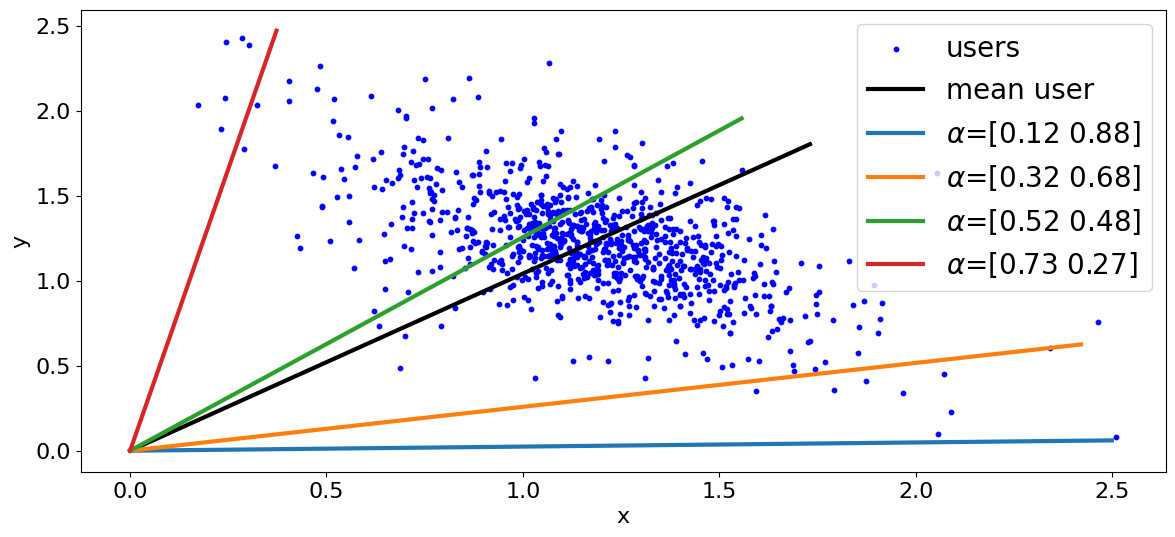

In [69]:

width = 14
height = 6

# Read data from files
p_vals_weighted2 = np.loadtxt('./Data/p_vals_weighted2.txt')
user_embeddings_weighted2 = np.loadtxt('./Data/user_embeddings_weighted2.txt')
mean_embedding_weighted2 = np.loadtxt('./Data/mean_embedding_weighted2.txt')

# Create a plot
fig, ax = plt.subplots(figsize=(width, height))

t = np.linspace(0, 2.5, 100)

x_coordinates = user_embeddings_weighted2[:, 0]
y_coordinates = user_embeddings_weighted2[:, 1]
plt.scatter(x_coordinates, y_coordinates, label='users', color='blue', s=10)  # reduced marker size to 10
plt.plot(t * mean_embedding_weighted2[0], t * mean_embedding_weighted2[1], label='mean user', color='k', linewidth=3)

# Assuming cost_weights_all_2d is saved and needs to be loaded as well
cost_weights_all_2d = np.loadtxt('./Data/cost_weights_all_2d.txt')
for i in range(len(p_vals_weighted2)):
    p = p_vals_weighted2[i]
    cost_weights = cost_weights_all_2d[i]
    plt.plot(t * p[0], t * p[1], label=f'$\\alpha$={np.around(cost_weights, 2)}', linewidth=3)

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./Plots/dim2-costs', bbox_inches='tight')




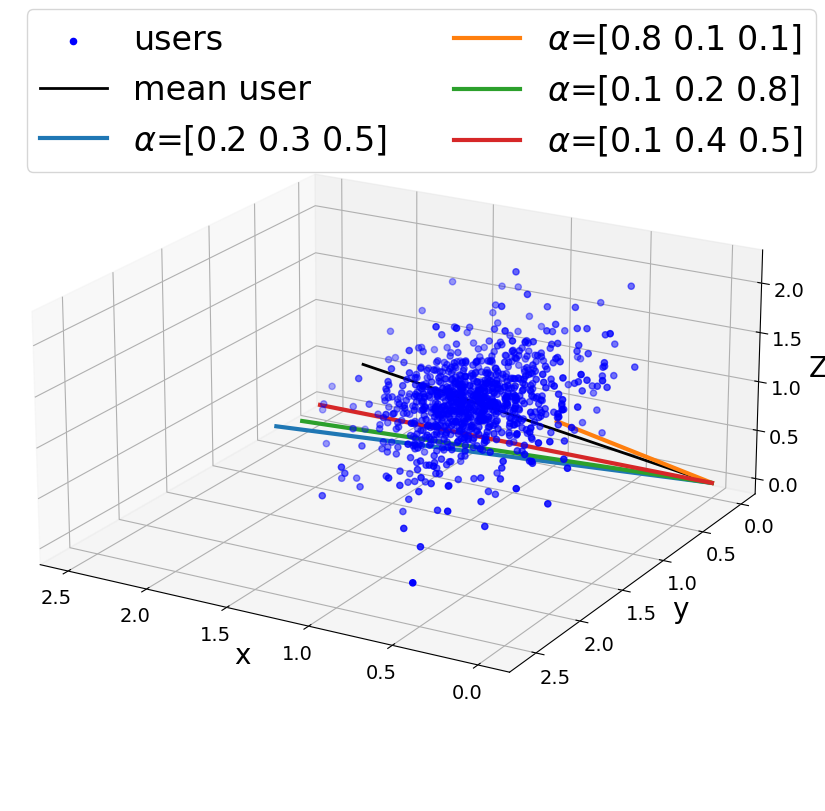

In [62]:


# Read data from files
cost_weights_all_3d = np.loadtxt('./Data/cost_weights_all_3d.txt')
p_vals_weighted3 = np.loadtxt('./Data/p_vals_weighted3.txt')
user_embeddings_weighted3 = np.loadtxt('./Data/user_embeddings_weighted3.txt')
mean_embedding_weighted3 = np.loadtxt('./Data/mean_embedding_weighted3.txt')

# Create a plot
width = 10
height = 10
fig, ax = plt.subplots(figsize=(width, height), subplot_kw={'projection': '3d'})

x_coordinates = user_embeddings_weighted3[:, 0]
y_coordinates = user_embeddings_weighted3[:, 1]
z_coordinates = user_embeddings_weighted3[:, 2]

t = np.linspace(0, 2.5, 100)

ax.scatter(x_coordinates, y_coordinates, z_coordinates, label='users', color='blue')
ax.plot(t * mean_embedding_weighted3[0], t * mean_embedding_weighted3[1], t * mean_embedding_weighted3[2], label='mean user', color='k', linewidth=2)

for i in range(len(p_vals_weighted3)):
    p = p_vals_weighted3[i]
    cost_weights = cost_weights_all_3d[i]
    ax.plot(t * p[0], t * p[1], t * p[2], label=f'$\\alpha$={np.around(cost_weights, 1)}', linewidth=3)


ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
ax.tick_params(labelsize=14)
aspect_x = 6.0
aspect_y = 6.0
aspect_z = 3.0
ax.set_box_aspect([aspect_x, aspect_y, aspect_z])
ax.view_init(elev=20, azim=120)
plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(0.0, 1.05), ncol=2)
plt.savefig('./Plots/dim3-costs', bbox_inches='tight')


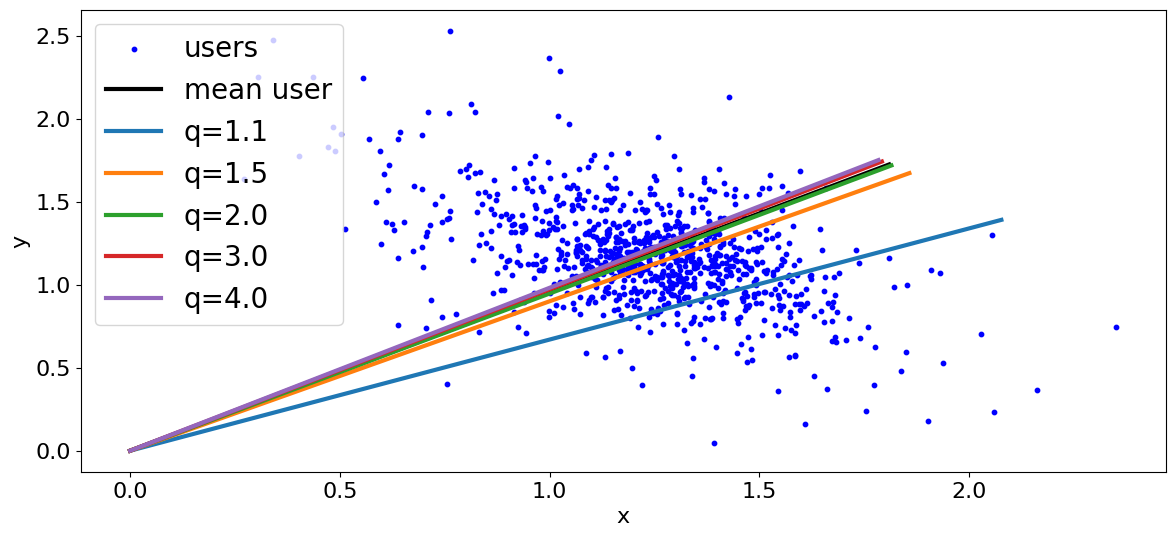

In [70]:
# Read data from files
p_vals_qvals2 = np.loadtxt('./Data/p_vals_qvals2.txt')
user_embeddings_qvals2 = np.loadtxt('./Data/user_embeddings_qvals2.txt')
mean_embedding_qvals2 = np.loadtxt('./Data/mean_embedding_qvals2.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')

# Create a plot
width = 14
height = 6
fig, ax = plt.subplots(figsize=(width, height))

t = np.linspace(0, 2.5, 100)

x_coordinates = user_embeddings_qvals2[:, 0]
y_coordinates = user_embeddings_qvals2[:, 1]
plt.scatter(x_coordinates, y_coordinates, label='users', color='blue', s=10)
plt.plot(t * mean_embedding_qvals2[0], t * mean_embedding_qvals2[1], label='mean user', color='k', linewidth=3)

for i in range(len(p_vals_qvals2)):
    p = p_vals_qvals2[i]
    q = q_vals[i]
    plt.plot(t * p[0], t * p[1], label=f'q={q}', linewidth=3)

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./Plots/dim2-q', bbox_inches='tight')


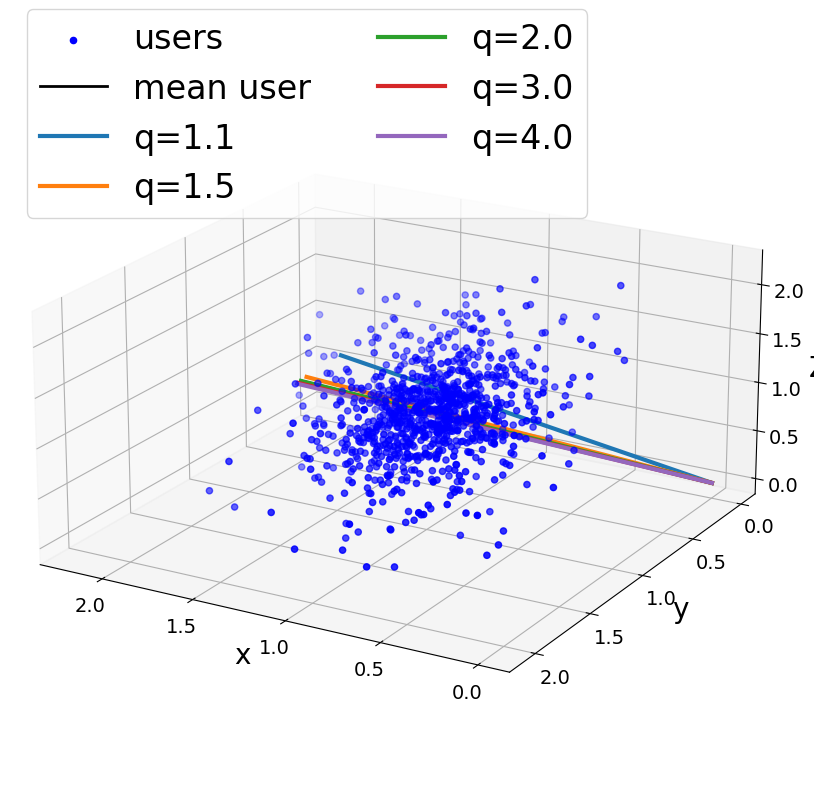

In [66]:

# Read data from files
p_vals_qvals3 = np.loadtxt('./Data/p_vals_qvals3.txt')
user_embeddings_qvals3 = np.loadtxt('./Data/user_embeddings_qvals3.txt')
mean_embedding_qvals3 = np.loadtxt('./Data/mean_embedding_qvals3.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')

# Create a plot
width = 10
height = 10
fig, ax = plt.subplots(figsize=(width, height), subplot_kw={'projection': '3d'})

t = np.linspace(0, 2.5, 100)

ax.scatter(user_embeddings_qvals3[:, 0], user_embeddings_qvals3[:, 1], user_embeddings_qvals3[:, 2], label='users', color='blue')
ax.plot(t * mean_embedding_qvals3[0], t * mean_embedding_qvals3[1], t * mean_embedding_qvals3[2], label='mean user', color='k', linewidth=2)

for i in range(len(p_vals_qvals3)):
    p = p_vals_qvals3[i]
    q = q_vals[i]
    ax.plot(t * p[0], t * p[1], t * p[2], label=f'q={q}', linewidth=3)

ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
ax.tick_params(labelsize=14)
aspect_x = 6.0
aspect_y = 6.0
aspect_z = 3.0
ax.set_box_aspect([aspect_x, aspect_y, aspect_z])
ax.view_init(elev=20, azim=120)
plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(0.0, 1.05), ncol=2)
plt.savefig('./Plots/dim3-q', bbox_inches='tight')


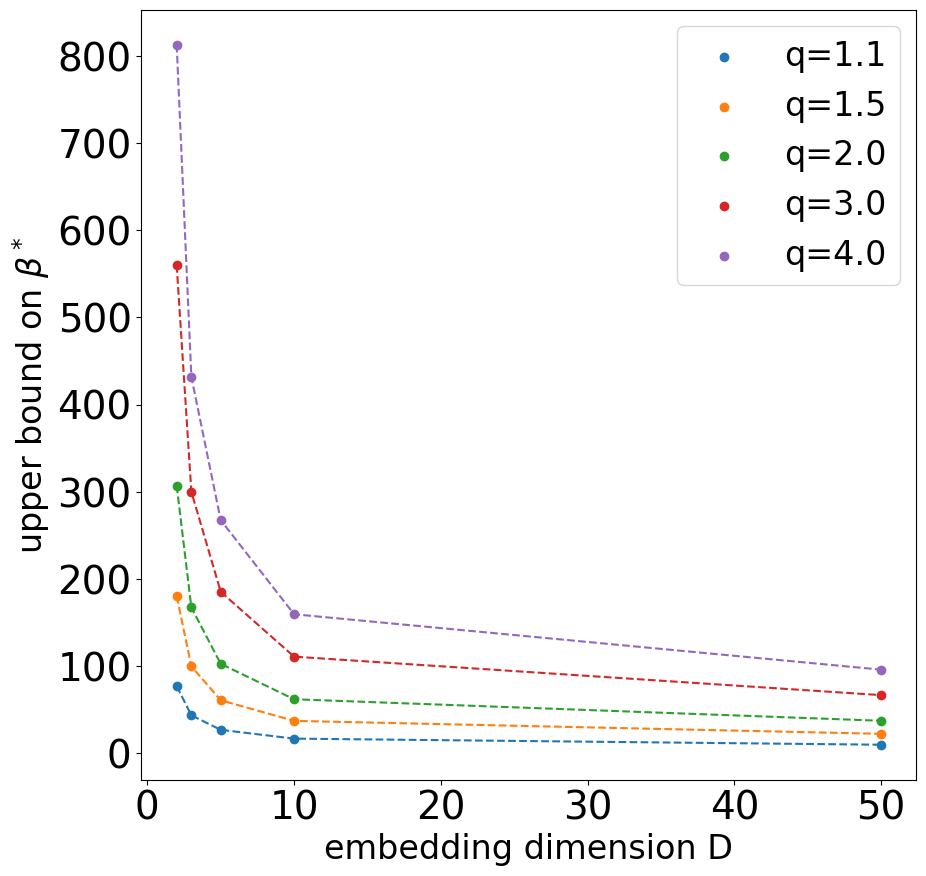

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from files
betas = np.loadtxt('./Data/betas.txt')
q_vals = np.loadtxt('./Data/q_vals.txt')
dim_values = np.loadtxt('./Data/dim_values.txt')

width=10
height = 10
fig, ax = plt.subplots(figsize=(width, height))

# Create a plot
for i in range(len(q_vals)):
    betas_val = betas[:, i]
    plt.scatter(dim_values, betas_val, label='q='+str(q_vals[i]), color = 'C'+str(i))
    plt.plot(dim_values, betas_val, '--', color = 'C'+str(i))

plt.legend(fontsize=24)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('embedding dimension D', fontsize=24)
plt.ylabel('upper bound on $\\beta^*$', fontsize=24)
plt.savefig('./Plots/beta-q', bbox_inches='tight')
